<h1>Import</h1>

In [48]:
from collections import Counter
import kaggle as kg
import zipfile as zf
import dask.dataframe as df
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf, row_number

import ast
import json

import sklearn 

<h2>Load and process data</h2>

In [62]:
movies_df = pd.read_csv('data/movies_metadata.csv')
movies_df = movies_df[['id', 'original_title', 'genres', 'release_date', 'vote_average', 'vote_count']]
movies_df = movies_df.dropna(subset=['original_title', 'genres'])
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')

ratings_df = pd.read_csv('data/ratings.csv')
ratings_df = ratings_df[['userId', 'movieId', 'rating', 'timestamp']]

ratings_df['userId'] = ratings_df['userId'].astype(int)
ratings_df['movieId'] = ratings_df['movieId'].astype(int)
ratings_df['rating'] = ratings_df['rating'].astype(float)

keywords_df = df.read_csv('data/keywords.csv', delimiter=',', header=0, dtype=str)
keywords_df = keywords_df[['id', 'keywords']]

C:\Users\Krish\AppData\Local\Temp\ipykernel_25916\657626775.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('data/movies_metadata.csv')


In [37]:
movies_df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [16]:
ratings_df.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


In [6]:
keywords_df.head(3)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."


<h2>Pivot Table<h2>

<p>Using the user ratings, create a user item matrix with pivot table. Due to machine constraints, a random sample of reviews was used to create the pivot table</p>

In [65]:
from scipy.sparse import csr_matrix


# # Convert 'movieId' column to category dtype and ensure known categories
# ratings_df['movieId'] = ratings_df['movieId'].astype('category')
# ratings_df['movieId'] = ratings_df['movieId'].cat.as_known()

# # Create a pivot table
# pivot_table = ratings_df.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean')

# # Compute the pivot table
# pivot_table = pivot_table.compute()

# # Group by userId and movieId and compute the mean rating
# pivot_table = ratings_df.groupby(['userId', 'movieId'])['rating'].mean().reset_index()


# -----------
sample_size = 100000  # Specify the desired sample size
sample_ratings = ratings_df.sample(n=sample_size, random_state=42)

# Create a pivot table to represent the user-item rating matrix
pivot_table = sample_ratings.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

pivot_table

movieId,1,2,3,4,5,6,7,8,9,10,...,172707,172799,172837,172989,173241,173943,174053,174055,174615,174665
userId,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>Attempted to scale pivot table to help with silouhette score performances<h3>

In [21]:
from sklearn.preprocessing import StandardScaler

# Apply feature scaling to the pivot table
scaler = StandardScaler()
scaled_pivot_table = scaler.fit_transform(pivot_table)

scaled_pivot_table.head(3)

<p>Here we take a look at what our sample looks like visually, to get a more interesting graph we target the top users and top rated movies only. However, it is important to note that the actual sample pivot table is much more empty</p>

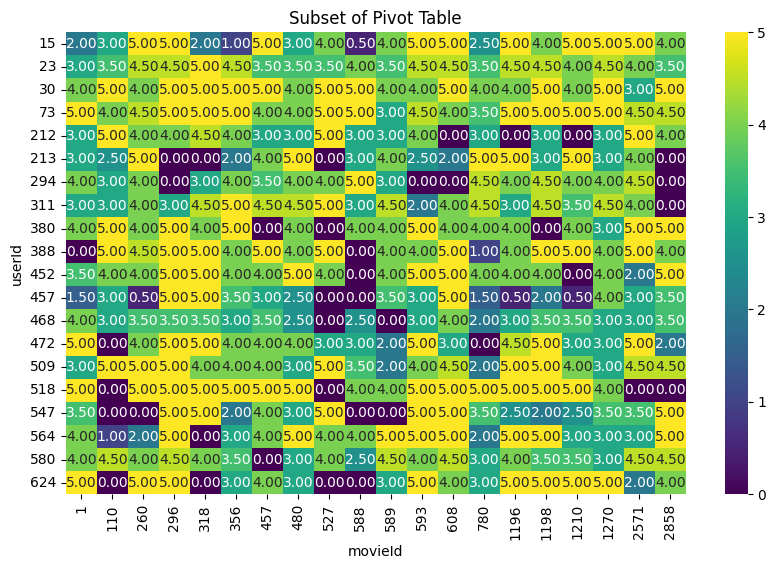

In [58]:
# Compute rating counts for users and movies
user_rating_counts = ratings_df['userId'].value_counts()
movie_rating_counts = ratings_df['movieId'].value_counts()

# Sort users and movies based on rating counts
top_users = user_rating_counts.index[:20]
top_movies = movie_rating_counts.index[:20]

# Filter ratings_df to keep only ratings from top users and top movies
top_ratings_df = ratings_df[(ratings_df['userId'].isin(top_users)) & (ratings_df['movieId'].isin(top_movies))]

# Create pivot table from the filtered ratings
pivot_table_sample = top_ratings_df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

# Visualize the pivot table
subset_pivot_table = pivot_table_sample.iloc[:50, :50]  # Select a subset for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(subset_pivot_table, cmap='viridis', annot=True, fmt='.2f')
plt.title('Subset of Pivot Table')
plt.xlabel('movieId')
plt.ylabel('userId')
plt.show()

<h4>New Attempt at creating a pivot table<h4>

In [39]:
ratings_table = pd.pivot_table(ratings_df, index='userId', columns='movieId', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', ratings_table.shape, '\n\nSubset example:')
ratings_table.iloc[:6, :10]

dataset dimensions:  (671, 9066) 

Subset example:


movieId,1,2,3,4,5,6,7,8,9,10
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
from scipy.sparse import csr_matrix

# Conversion to sparse csr matrix directly from DataFrame
sparse_ratings = csr_matrix(ratings_table)

<h2>KMeans Clustering</h2>

<p>Arbitrary number of clusters (5)

In [59]:
from sklearn.cluster import KMeans

# Apply k-means clustering
num_clusters = 5  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(pivot_table)

cluster_labels

array([4, 2, 4, 1, 4, 4, 2, 1, 4, 4, 4, 4, 4, 4, 3, 4, 0, 4, 3, 4, 1, 1,
       3, 4, 4, 0, 4, 4, 4, 3, 4, 2, 4, 1, 4, 2, 4, 4, 2, 4, 1, 4, 4, 4,
       4, 4, 2, 0, 4, 2, 4, 4, 4, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 2, 4, 4,
       2, 1, 4, 4, 4, 0, 0, 4, 4, 4, 1, 0, 4, 4, 4, 2, 1, 4, 2, 2, 4, 1,
       4, 4, 4, 2, 1, 0, 1, 4, 4, 4, 1, 4, 4, 3, 4, 4, 1, 4, 4, 2, 4, 2,
       1, 4, 4, 2, 4, 4, 4, 1, 3, 1, 2, 2, 4, 4, 0, 2, 4, 1, 4, 1, 4, 4,
       4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 0, 1, 2, 0, 4, 4,
       4, 4, 0, 4, 1, 4, 2, 4, 4, 4, 1, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       1, 4, 4, 4, 4, 2, 4, 2, 1, 4, 1, 2, 4, 4, 2, 2, 4, 2, 3, 4, 4, 4,
       0, 0, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 1, 4, 4, 4, 4, 1, 1,
       4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 3, 4, 4, 1, 4, 4, 4, 1, 1, 2, 3,
       1, 4, 1, 4, 1, 4, 4, 0, 4, 4, 1, 2, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4,
       4, 2, 4, 0, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 2, 4, 4, 1, 4, 4, 1, 4,
       0, 2, 4, 4, 4, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4,

<h4>Attempting to find perfect number of clusters using Elbow method and Silouhette scores<h4>

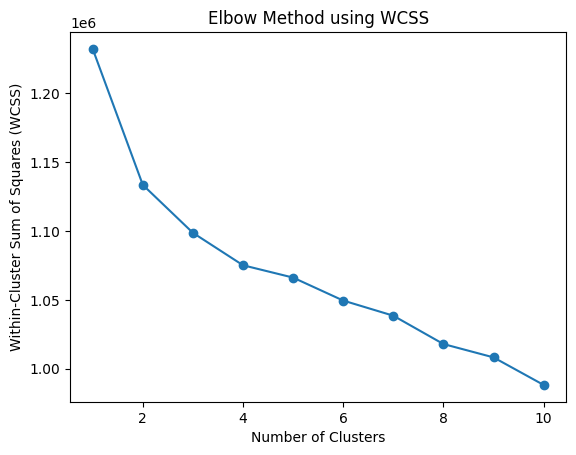

In [60]:
# ELBOW METHOD
import matplotlib.pyplot as plt

# List to store WCSS values for different numbers of clusters
wcss_values = []

# Range of cluster numbers to try
cluster_range = range(1, 11)

# Calculate WCSS for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pivot_table)
    wcss_values.append(kmeans.inertia_)  # Inertia is the WCSS value

# Plot the elbow curve
plt.plot(cluster_range, wcss_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method using WCSS')
plt.show()




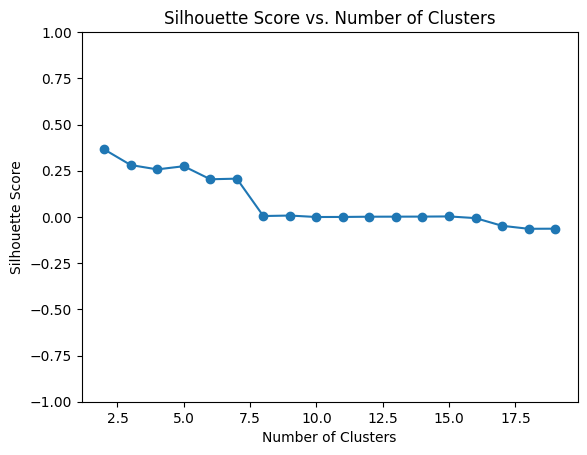

In [61]:
# SILOUHETTE SCORES
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Initialize a list to store silhouette scores for different numbers of clusters
silhouette_scores = []

# Range of cluster numbers to try
cluster_range = range(2, 20)  # Start from 2 clusters

# Calculate silhouette score for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pivot_table)  # X is your data matrix
    silhouette_avg = silhouette_score(pivot_table, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.ylim(-1, 1)  # Set y-axis limits
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

<p>Recalculating the cluster_labels with new number of clusters<p>

In [61]:
# Apply k-means clustering
num_clusters = 11  # Choose the number of clusters after elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(pivot_table)

cluster_labels

array([1, 1, 1, ..., 1, 1, 1])

<h4>Re-attempting kmeans<h4>

<h3>Attempting to vizualize the clusters</h3>

MemoryError: Unable to allocate 4.07 GiB for an array with shape (546461500,) and data type int64

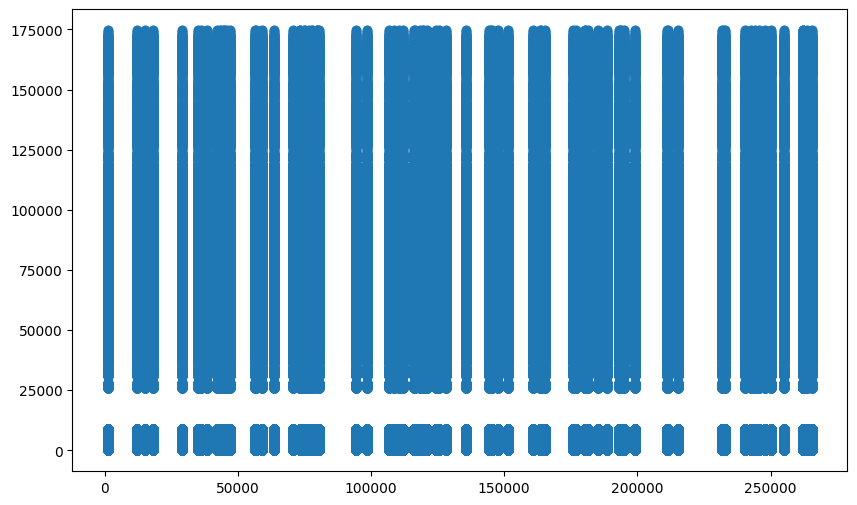

In [66]:
import matplotlib.pyplot as plt
 
# Reshape the pivot table into long format
pivot_table_long = pivot_table.stack().reset_index(name='rating')

# Repeat each cluster label for each user-movie pair
cluster_labels_long = np.repeat(cluster_labels, pivot_table.shape[1])

# Add cluster labels to the long format DataFrame
pivot_table_long['cluster'] = cluster_labels_long

# Plotting the clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_points = pivot_table_long[pivot_table_long['cluster'] == i]
    plt.scatter(cluster_points['userId'], cluster_points['movieId'], label=f'Cluster {i+1}')

plt.xlabel('User ID')
plt.ylabel('Movie ID')
plt.title('K-means Clustering of Movie Ratings')
plt.legend()
plt.grid(True)
plt.show()

<h2>Example, getting recommendation for a specific user<h2>

In [78]:
# Example: Get top-rated movies for user 8000 with movie names

# User ID
user_id = 8659

# Get the ratings of user 8000 from the pivot table
user_ratings = pivot_table.loc[user_id]

# Sort the ratings in descending order to get the top-rated movies
top_rated_movies = user_ratings.sort_values(ascending=False)

# Select the top 5 movies
top_5_movies = top_rated_movies.head(5)

# Convert index to int in top_5_movies
top_5_movies.index = top_5_movies.index.astype('int')

# Concatenate top_5_movies DataFrame and movies_df DataFrame along the columns axis
top_movies_with_names = pd.concat([top_5_movies, movies_df.set_index('id')], axis=1, join='inner')

# Display the top-rated movies with names
print("Top-rated movies for user", user_id, ":")
for idx, row in top_movies_with_names.iterrows():
    print("Movie Name:", row['title'], "Rating:", row[user_id])

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [70]:
# Example: Get recommendations for a given user
user_id = 8659

# Get the cluster label for the given user
user_cluster_label = cluster_labels[user_id - 1]

# Get all users in the same cluster as the given user
users_in_same_cluster = pivot_table.index[cluster_labels == user_cluster_label]

# Exclude the given user from the list of users in the same cluster
users_in_same_cluster = users_in_same_cluster.drop(user_id)

# Get the average ratings of the users in the same cluster
average_ratings = pivot_table.loc[users_in_same_cluster].mean()

# Sort the average ratings in descending order
sorted_ratings = average_ratings.sort_values(ascending=False)

# Example: Get top-k recommendations
k = 5
top_k_recommendations = sorted_ratings.head(k)

# Print the top-k recommendations
print("Top", k, "recommendations for user", user_id, ":")
for product_id, rating in top_k_recommendations.items():
    print("Movie ID:", product_id, "Rating:", rating)


Top 5 recommendations for user 8659 :
Product ID: 318 Rating: 0.027535831939150383
Product ID: 356 Rating: 0.02630262681315649
Product ID: 593 Rating: 0.024301902412942618
Product ID: 296 Rating: 0.0239052070577278
Product ID: 2571 Rating: 0.02113696338329395
